In [112]:
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import matplotlib.cm as cm
import cPickle as pickle
import helpers
import plots
import pandas as pd
import glob
import plot_ts
import fwd_likelihoods as fl
reload(plots)
reload(helpers)

<module 'helpers' from 'helpers.pyc'>

In [113]:
print 'Loading posterior mean dataframe'
df = pickle.load(open('pm_df.p', 'rb'))

print 'Loading posterior sample dictionary'
data_dict = pickle.load(open('indiv_dict.p', 'rb'))

print 'Loading group sample dictionary'
group_dict = pickle.load(open('group_dict.p', 'rb'))

Loading posterior mean dataframe
Loading posterior sample dictionary
Loading group sample dictionary


In [131]:
def plot_IMI(data_dir, data_dict, cutoff=300, num_samples=10):
    windowsize = 5
    err_thresh = 28800
    
    p_lengths = []
    g_ends = []
    c = []

    ## Assemble dataset
    count = len(os.listdir(data_dir))
    for i, dataset in enumerate(os.listdir(data_dir)):
        data = np.loadtxt(data_dir+dataset, delimiter='\t', usecols=(0,1,2,3,4))

        for j in data:
            f_lengths, g_starts, rates, p_length, g_end = j

            if p_length > cutoff:
                p_lengths.append(p_length)
                g_ends.append(g_end)
                c.append(float(i)/count)

            if p_length > err_thresh:
                print 'Error in %s, IMI of %3.0f' %(dataset, p_length)

    ## Process to use in moving window
    results = zip(g_ends, p_lengths)
    results = np.array(results)

    ## Generate moving window mean
    x_grid = np.linspace(0, 30, 50)

    means = []
    for xval in x_grid:
        usevals = np.abs(results[:,0] - xval) < windowsize
        meanval = np.mean(results[usevals, 1])
        means.append(meanval)

    """
    for i in results:
        print '%3.3f\t%3.3f' %(i[0], i[1])
    """
    means = np.array(means)

    ## Plot moving window
    fig, axes = plt.subplots(1)
    axes.scatter(results[:,0], 
                 results[:,1], 
                 alpha=1.0, 
                 c=c, 
                 cmap=cm.gist_ncar)
    
    axes.plot(x_grid, means, c='k')
    
    ## Generate posterior predictive curve
    post = data_dict[data_dir.split('/')[1]+'_trace.p']
    post = np.mean(post, axis=0)
    
    mean_ppcs = []
    k1 = 0.00055
    for xval in x_grid:
        samples = []
        for i in range(num_samples):
            theta7 = np.power(10., post[6])
            theta8 = np.power(10., post[7])
            samples.append(fl.sample_L(xval, k1, theta7, theta8))
            
        mean_ppcs.append(np.mean(samples))
        
    axes.plot(x_grid, mean_ppcs, c='r')
    
    plt.show()

vehicle_0.0_A_D


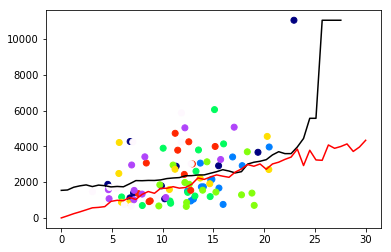

LiCl_32.0_A_D


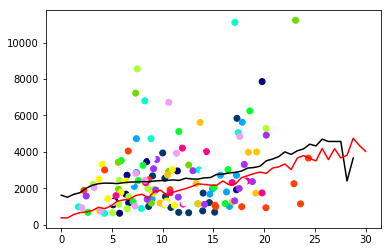

PYY_7.5_A_D


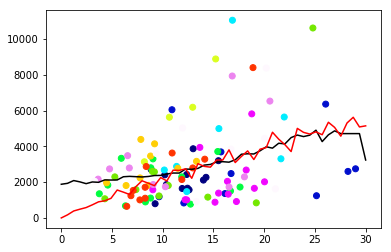

GLP-1_300.0_A_D


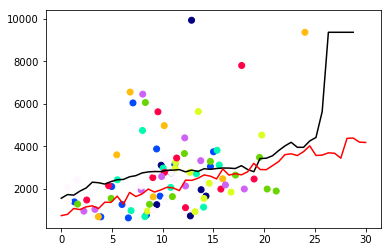

PYY_300.0_A_D


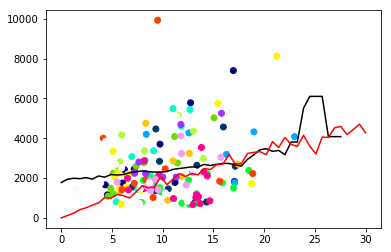

sib_0.9_A_D


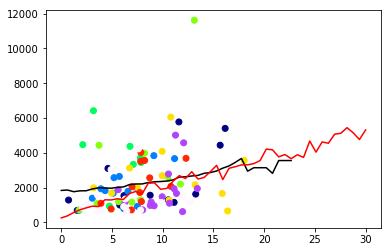

saline_0.0_R_L
Error in saline_0.0_R_L_1_8_2014-11-10.B0101.CSV, IMI of 66624
Error in saline_0.0_R_L_5_8_2014-11-10.B0105.CSV, IMI of 59039
Error in saline_0.0_R_L_12_8_2014-11-10.B0112.CSV, IMI of 66083
Error in saline_0.0_R_L_4_8_2014-11-10.B0104.CSV, IMI of 30051
Error in saline_0.0_R_L_13_8_2014-11-10.B0113.CSV, IMI of 59517


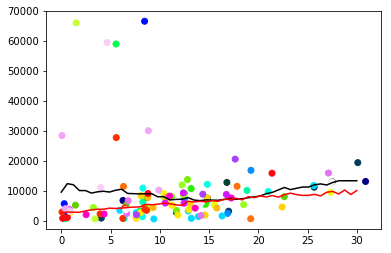

LiCl_64.0_R_L


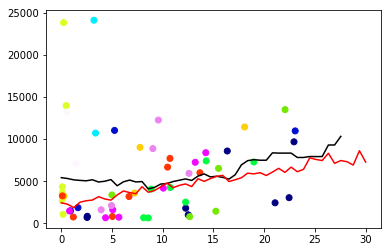

PYY_1.5_R_L


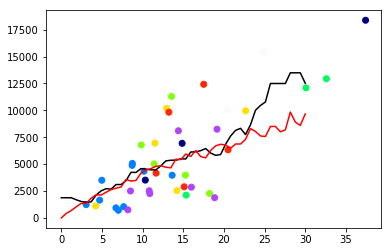

Ex-4_0.3_A_D


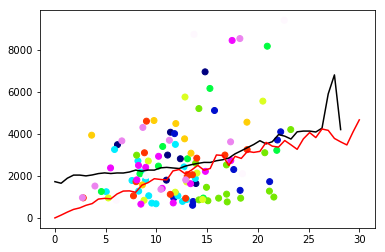

PYY_7.5_R_L


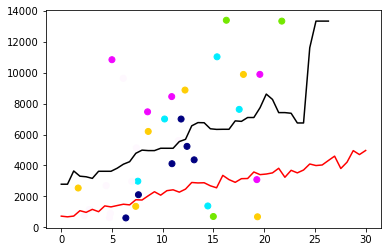

Lep_2.0_A_D


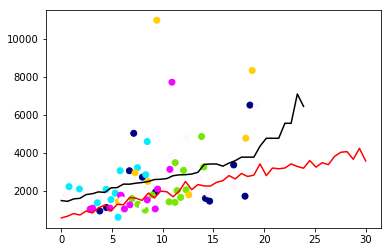

LiCl_32.0_R_L
Error in LiCl_32.0_R_L_5_8_2014-11-03.B0105.CSV, IMI of 29468


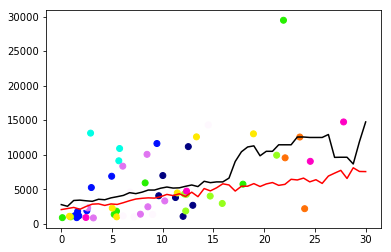

saline_0.0_R_D


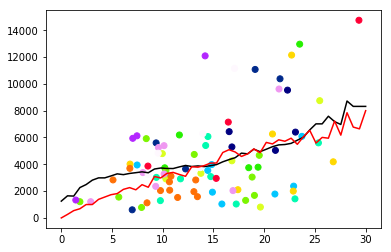

saline_0.0_A_D


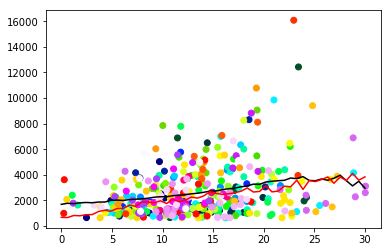

GLP-1_100.0_A_D


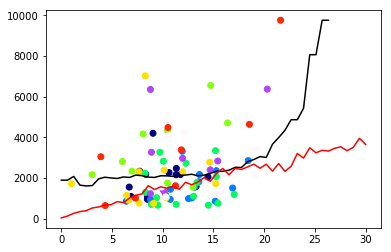

saline_0.0_A_L


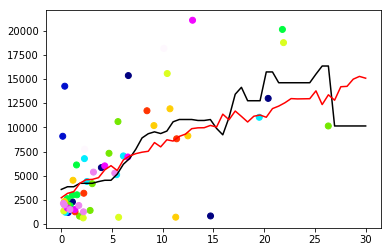

PYY_1.5_A_D


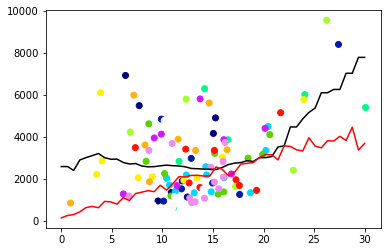

GLP-1_30.0_A_D


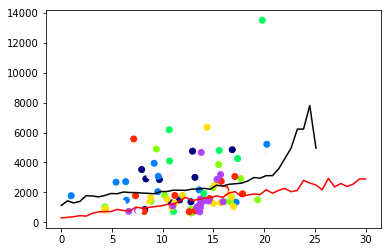

PYY_300.0_R_L


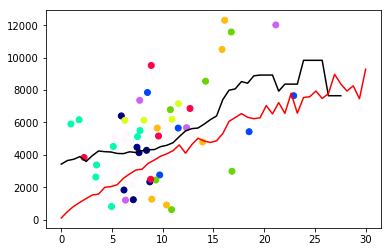

LiCl_16.0_R_L
Error in LiCl_16.0_R_L_7_8_2014-11-10.B0107.CSV, IMI of 61168
Error in LiCl_16.0_R_L_10_8_2014-11-10.B0110.CSV, IMI of 58984
Error in LiCl_16.0_R_L_11_8_2014-11-10.B0111.CSV, IMI of 60612
Error in LiCl_16.0_R_L_3_8_2014-11-10.B0103.CSV, IMI of 29894
Error in LiCl_16.0_R_L_3_8_2014-11-10.B0103.CSV, IMI of 30873
Error in LiCl_16.0_R_L_6_8_2014-11-10.B0106.CSV, IMI of 60124


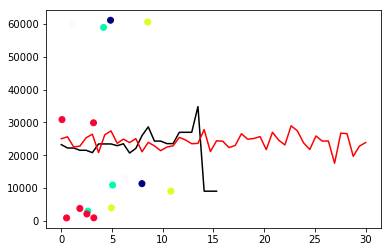

In [132]:
root_dir = 'new_all_data/'
cutoff = 600
num_samples = 100
for i in os.listdir(root_dir):
    print i
    data_dir = root_dir + i + '/'
    plot_IMI(data_dir, group_dict, cutoff=cutoff, num_samples=num_samples)